In [1]:
import numpy as np # linear algebra
import math
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/new-data-avto-12-brends/new_data_avto_12_brends.csv


In [2]:
# parsing libraries

from bs4 import BeautifulSoup as BS
import requests as rs
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import chain
import json
import time

# Statistical significance
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

#ml

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.base import clone

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
RANDOM_SEED = 42

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 0. Подготовим классы и функции

In [6]:
# класс для построения визуализация для числового признака и нахождения выбросов.

class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 1. Просмотор данных 

In [8]:
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')
test['price'] = np.nan
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   complectation_dict    6418 non-null   object 
 5   description           34686 non-null  object 
 6   engineDisplacement    34686 non-null  object 
 7   enginePower           34686 non-null  object 
 8   equipment_dict        24690 non-null  object 
 9   fuelType              34686 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               34686 non-null  int64  
 12  modelDate             34686 non-null  int64  
 13  model_info            34686 non-null  object 
 14  model_name            34686 non-null  object 
 15  name               

**Вывод**

1. В DataFram (DF) 32 столбца, 33 добавлен как целевое значение функции
2. В DF 4 числовых столбцев: mileage, numberOfDoors, sell_id, price
3. В DF 3 временных признака: modelDate, productionDate,parsing_unixtime
4. В DF 15 категориальных признаков: 'bodyType', 'brand', 'color', 'fuelType', 'model_name',         'priceCurrency', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня'
5. В DF 11 столбцев, которые можно отнести к описательным

Просмотрим количество категориальных признаково

In [10]:
categories = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 
              'priceCurrency', 'vehicleTransmission', 'vendor', 'Владельцы', 
               'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
count = 1
for category in categories:
    data_category = test[category].value_counts()
    print(f'{count}. Категория {category}: наиболее распостраненная {data_category.index[0]}, количество категорий {len(data_category)}')
    count += 1

1. Категория bodyType: наиболее распостраненная седан, количество категорий 24
2. Категория brand: наиболее распостраненная BMW, количество категорий 12
3. Категория color: наиболее распостраненная чёрный, количество категорий 16
4. Категория fuelType: наиболее распостраненная бензин, количество категорий 5
5. Категория model_name: наиболее распостраненная OCTAVIA, количество категорий 544
6. Категория priceCurrency: наиболее распостраненная RUB, количество категорий 1
7. Категория vehicleTransmission: наиболее распостраненная автоматическая, количество категорий 4
8. Категория vendor: наиболее распостраненная EUROPEAN, количество категорий 2
9. Категория Владельцы: наиболее распостраненная 3 или более, количество категорий 3
10. Категория ПТС: наиболее распостраненная Оригинал, количество категорий 2
11. Категория Привод: наиболее распостраненная передний, количество категорий 3
12. Категория Руль: наиболее распостраненная Левый, количество категорий 2
13. Категория Состояние: наиболе

**Вывод**

1. Как видно, такие столбцы как Таможня, Состояние, priceCurrency не имеют значимости для рассчета цены автомобиля
2. Можно сделать гипотизу о том, что в значительное влияние на значение цены оказывает бренд и, соотвественно, проводить определение цены в разрезе бренда

# 2. Парсинг

Т.к. ранее было выявлено 12 брендов, то составим парсинг с avto.ru этих 12 брендов. Для начала определим список брендов:

In [11]:
test.brand.value_counts().index

Index(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI', 'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI', 'LEXUS'], dtype='object')

In [12]:
# Парсинг проводился по слующим критериям 'bodyType', 'brand', 'color', 
#'fuelType', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'price', 'name', 'engineDisplacemen', 'enginePower', 'mileage'

"""

model_all = ['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI', 'MITSUBISHI', 'SKODA', 
             'VOLVO', 'HONDA', 'INFINITI', 'LEXUS']

auto_list_long =[]

for brand in model_all:  # марка авто
    print(brand)
    for i in range(1, 1200):     # кол-во страниц для парсинга с авто.ру   
        print(i)
        response = rs.get(f'https://auto.ru/moskva/cars/{brand}/used/?output_type=list&page={i}')
        if response.status_code != 200:
            raise BaseException("response code" + str(response.status_code))
        response.encoding = 'utf-8'
        soup = BS(response.text, 'html.parser')
        page = soup.find_all('div', class_='ListingItem-module__container')  
        for k in range(len(page)):     # цикл для прохода по объявлениям в одной странице
            auto_html = page[k].find_all('meta')
            auto_list = []
            for i in range(len(auto_html)):   # цикл для обработки отдельного объявления на странице
                auto_list.append((str(auto_html[i])[15:]).split('"', 1)[0])
                
            # Убираем лишние параметры автомобиля из списка    
            pos_out = {4,11,12,14,15,19}
            auto_list_short = []
            for n in range(len(auto_list)):   # цикл для удаления лишних параметров из объявления
                if n not in pos_out:
                    auto_list_short.append(auto_list[n].replace('\xa0', ' ')) 
        
            # Считываем пробег(он расположен отдельно от других данных)    
            all_km = page[k].find('div', class_='ListingItem-module__kmAge')
            xx = str(all_km)[39:].split('<', 1)[0].replace('\xa0', ' ')
            auto_list_short.append(str(xx))    # добавляем пробег
            auto_list_long.append(auto_list_short)    # добавляем список пар-ров автомобиля в список списков

"""


'\n\nmodel_all = [\'BMW\', \'VOLKSWAGEN\', \'NISSAN\', \'MERCEDES\', \'TOYOTA\', \'AUDI\', \'MITSUBISHI\', \'SKODA\', \n             \'VOLVO\', \'HONDA\', \'INFINITI\', \'LEXUS\']\n\nauto_list_long =[]\n\nfor brand in model_all:  # марка авто\n    print(brand)\n    for i in range(1, 1200):     # кол-во страниц для парсинга с авто.ру   \n        print(i)\n        response = rs.get(f\'https://auto.ru/moskva/cars/{brand}/used/?output_type=list&page={i}\')\n        if response.status_code != 200:\n            raise BaseException("response code" + str(response.status_code))\n        response.encoding = \'utf-8\'\n        soup = BS(response.text, \'html.parser\')\n        page = soup.find_all(\'div\', class_=\'ListingItem-module__container\')  \n        for k in range(len(page)):     # цикл для прохода по объявлениям в одной странице\n            auto_html = page[k].find_all(\'meta\')\n            auto_list = []\n            for i in range(len(auto_html)):   # цикл для обработки отдельного о

In [13]:
DIR_TRAIN   = '..//input/new-data-avto-12-brends/'
train = pd.read_csv(DIR_TRAIN+'new_data_avto_12_brends.csv')

In [14]:
train.head()

,Unnamed: 0,bodyType,brand,color,engineDisplacemen,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price
0,0,внедорожник 5 дв.,BMW,синий,3.0 LTR,218 N12,дизель,68 500 км,2013.0,BMW X5 III (F15) 25d,3.0 AT,5.0,2018,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3600000.0
1,1,седан,BMW,чёрный,3.0 LTR,306 N12,бензин,58 000 км,2005.0,BMW 3 серии V (E90/E91/E92/E93) 335i xDrive,3.0 AT,4.0,2008,SEDAN AUTOMATIC 3.0,автоматическая,1250000.0
2,2,купе,BMW,красный,2.0 LTR,190 N12,дизель,4 000 км,2017.0,BMW 4 серии F32/F33/F36 Рестайлинг 420d,2.0 AT,2.0,2019,COUPE AUTOMATIC 2.0,автоматическая,2900000.0
3,3,внедорожник 5 дв.,BMW,серый,3.0 LTR,249 N12,дизель,3 859 км,2018.0,BMW X7 I (G07) 30d,3.0 AT,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,8549000.0
4,4,внедорожник 5 дв.,BMW,чёрный,4.8 LTR,360 N12,бензин,253 200 км,2003.0,BMW X5 I (E53) Рестайлинг 4.8is,4.8 AT,5.0,2005,ALLROAD_5_DOORS AUTOMATIC 4.8,автоматическая,725000.0


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528706 entries, 0 to 528705
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            528706 non-null  int64  
 1   bodyType              528704 non-null  object 
 2   brand                 528706 non-null  object 
 3   color                 528706 non-null  object 
 4   engineDisplacemen     528706 non-null  object 
 5   enginePower           528706 non-null  object 
 6   fuelType              528704 non-null  object 
 7   mileage               528706 non-null  object 
 8   modelDate             528704 non-null  float64
 9   model_name            528706 non-null  object 
 10  name                  528704 non-null  object 
 11  numberOfDoors         528704 non-null  float64
 12  productionDate        528706 non-null  int64  
 13  vehicleConfiguration  528704 non-null  object 
 14  vehicleTransmission   528704 non-null  object 
 15  

In [16]:
#удалим пропуски из нового train

train = train.dropna()
train = train.drop('Unnamed: 0', axis = 1)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515446 entries, 0 to 528705
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              515446 non-null  object 
 1   brand                 515446 non-null  object 
 2   color                 515446 non-null  object 
 3   engineDisplacemen     515446 non-null  object 
 4   enginePower           515446 non-null  object 
 5   fuelType              515446 non-null  object 
 6   mileage               515446 non-null  object 
 7   modelDate             515446 non-null  float64
 8   model_name            515446 non-null  object 
 9   name                  515446 non-null  object 
 10  numberOfDoors         515446 non-null  float64
 11  productionDate        515446 non-null  int64  
 12  vehicleConfiguration  515446 non-null  object 
 13  vehicleTransmission   515446 non-null  object 
 14  price                 515446 non-null  float64
dtype

In [18]:
train['mileage'] = train['mileage'].apply(lambda x: x.replace(' ', '').replace('км', ''))

In [19]:
for column in ['mileage', 'modelDate', 'numberOfDoors', 'price']:
    train[column] = train[column].astype('int64')

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515446 entries, 0 to 528705
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   bodyType              515446 non-null  object
 1   brand                 515446 non-null  object
 2   color                 515446 non-null  object
 3   engineDisplacemen     515446 non-null  object
 4   enginePower           515446 non-null  object
 5   fuelType              515446 non-null  object
 6   mileage               515446 non-null  int64 
 7   modelDate             515446 non-null  int64 
 8   model_name            515446 non-null  object
 9   name                  515446 non-null  object
 10  numberOfDoors         515446 non-null  int64 
 11  productionDate        515446 non-null  int64 
 12  vehicleConfiguration  515446 non-null  object
 13  vehicleTransmission   515446 non-null  object
 14  price                 515446 non-null  int64 
dtypes: int64(5), obje

In [21]:
train[train['bodyType'] == 'внедорожник 5 дв.']['brand'].value_counts()

MITSUBISHI    36088
INFINITI      34884
LEXUS         32317
NISSAN        30913
VOLVO         28952
HONDA         27252
BMW           21218
TOYOTA        19963
MERCEDES      19699
AUDI          19598
VOLKSWAGEN    17493
SKODA         12014
Name: brand, dtype: int64

In [22]:
len(train['brand'].value_counts())

12

In [23]:
brand = list(test['brand'].value_counts().index)
brand_1 = brand.copy()

In [24]:
for i in brand:
    brand_1.remove(i)
    for j in brand_1:
        if ttest_ind(train[(train['brand'] == i) & (train['bodyType'] == 'внедорожник 5 дв.')].price, train[(train['brand'] == j) & (train['bodyType'] == 'внедорожник 5 дв.')].price).pvalue <= 0.01:
            print(f'Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов {i} и {j}')

Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и VOLKSWAGEN
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и NISSAN
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и MERCEDES
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и TOYOTA
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и AUDI
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и MITSUBISHI
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и SKODA
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и VOLVO
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и HONDA
Найдены статистически значимые различия в стоимости внедорожник 5 дв. для брендов BMW и INFINITI
Найдены статистически значимые различия в с

**Вывод**

Как видно есть статистически значимая разница в ценах между брендами, поэтому будем использовать 12 обученных моделей по определению цены для каждого бренда.

In [25]:
display(test.sample(1), train.sample(1))

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
3163,седан,AUDI,https://auto.ru/cars/used/sale/audi/a4/1101191...,синий,NaN,Автомобиль на ходу. Есть незначительные косяки...,2.0 LTR,130 N12,"{""engine-proof"":true,""cruise-control"":true,""as...",бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,224095,2004,"{""code"":""A4"",""name"":""A4"",""ru_name"":""А4"",""morph...",A4,2.0 CVT (130 л.с.),4,1603124675,RUB,2004,1101191951,"{""id"":""3480065"",""displacement"":1984,""engine_ty...",SEDAN VARIATOR 2.0,вариатор,EUROPEAN,3 или более,1 год и 10 месяцев,Дубликат,передний,Левый,Не требует ремонта,Растаможен,NaN


,bodyType,brand,color,engineDisplacemen,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price
488619,внедорожник 5 дв.,TOYOTA,чёрный,4.5 LTR,235 N12,дизель,135700,2012,Toyota Land Cruiser 200 Series Рестайлинг 1,4.5 AT,5,2014,ALLROAD_5_DOORS AUTOMATIC 4.5,автоматическая,2749000


In [26]:
display(test.name.sample(3), train.name.sample(3)) 

21102    1.6 AT (115 л.с.) 4WD
24354       2.5d AT (174 л.с.)
1269        1.4 AMT (150 л.с.)
Name: name, dtype: object

48474     1.4 MT
215929    3.8 AT
78511     2.0 AT
Name: name, dtype: object

**Вывод**

Сравнивая test и train, видим, что только признаки 'name' и 'model_name' имеют разные области значений. 
Признак name - это комбинация таких признаков как engineDisplacement, vehicleTransmission, vehicleConfiguration (признак bool(Allroad)).


In [27]:
#  Признак 'model_name'
display(test.model_name.value_counts()[:3], train.model_name.value_counts()[:3]) 

OCTAVIA    1418
5ER        1026
LANCER      855
Name: model_name, dtype: int64

Volvo XC90 I Рестайлинг      11053
Volvo XC60 I                  9317
Honda CR-V III Рестайлинг     6623
Name: model_name, dtype: int64

**Вывод**

Признак model_name в train более информативный и может оказать существенное влияние на значение цены, но для модели необходимо извлечь название модели

In [28]:
# Вырезаем названия моделей в train и меняем прописные буквы на заглавные 
train['model_name'] = train['model_name'].apply(lambda x: (x.split(' ')[1]).upper())

# Укорачиваем двойные названия
train['model_name'] = train['model_name'].apply(lambda x: x.split('-')[0])
test['model_name'] = test['model_name'].apply(lambda x: x.split('_')[0])

# Укорачиваем названия моделей, начинающися с цифры( это надо в основном для 'BMW') 
num_list = ['0','1','2','3','4','5','6','7','8','9']
train['model_name'] = train['model_name'].apply(lambda x: x[0] if x[0] in num_list else x)
test['model_name'] = test['model_name'].apply(lambda x: x[0] if x[0] in num_list else x)

In [29]:
# Проверка признаков

for i in brand:
    print(i)
    print(np.sort(test[test.brand == i].model_name.unique()))
    print(np.sort(train[train.brand == i].model_name.unique()))
    print(100*'-')

BMW
['0' '1' '2' '3' '4' '5' '6' '7' '8' 'E3' 'I3' 'I8' 'M1' 'M2' 'M3' 'M4'
 'M5' 'M6' 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'Z1' 'Z3' 'Z3M' 'Z4']
['0' '1' '2' '3' '4' '5' '6' '7' '8' 'E3' 'I3' 'I8' 'M2' 'M3' 'M4' 'M5'
 'M6' 'M8' 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'Z1' 'Z3' 'Z4']
----------------------------------------------------------------------------------------------------
VOLKSWAGEN
['AMAROK' 'ARTEON' 'ATLAS' 'BEETLE' 'BORA' 'CADDY' 'CALIFORNIA'
 'CARAVELLE' 'CORRADO' 'EOS' 'EUROVAN' 'FOX' 'GOLF' 'JETTA' 'LUPO'
 'MULTIVAN' 'PASSAT' 'PHAETON' 'POINTER' 'POLO' 'SCIROCCO' 'SHARAN' 'TARO'
 'TERAMONT' 'TIGUAN' 'TOUAREG' 'TOURAN' 'TRANSPORTER' 'TYPE' 'VENTO']
['AMAROK' 'ARTEON' 'BEETLE' 'BORA' 'CADDY' 'CALIFORNIA' 'CARAVELLE'
 'CORRADO' 'EOS' 'EUROVAN' 'FOX' 'GOLF' 'ILTIS' 'JETTA' 'LUPO' 'MULTIVAN'
 'PASSAT' 'PHAETON' 'POINTER' 'POLO' 'SCIROCCO' 'SHARAN' 'TERAMONT'
 'TIGUAN' 'TOUAREG' 'TOURAN' 'TRANSPORTER' 'TYPE' 'VENTO']
-----------------------------------------------------------------

In [30]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price'], dtype='object')

In [31]:
# Выбираем признаки для дальнейшей работы

columns = ['bodyType', 'brand', 'color', 'engineDisplacemen', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 
           'vehicleConfiguration', 'vehicleTransmission', 'price']

cars_train = train[columns]
#cars_test = test[columns]

In [32]:
cars_train.columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 
           'vehicleConfiguration', 'vehicleTransmission', 'price']

In [33]:
columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 
           'vehicleConfiguration', 'vehicleTransmission', 'price']
cars_test = test[columns]

In [34]:
cars_train['sample'] = 1
cars_test['sample'] = 0
all_cars = cars_train.append(cars_test, ignore_index=True, sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
all_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550132 entries, 0 to 550131
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              550132 non-null  object 
 1   brand                 550132 non-null  object 
 2   color                 550132 non-null  object 
 3   engineDisplacement    550132 non-null  object 
 4   enginePower           550132 non-null  object 
 5   fuelType              550132 non-null  object 
 6   mileage               550132 non-null  int64  
 7   modelDate             550132 non-null  int64  
 8   model_name            550132 non-null  object 
 9   numberOfDoors         550132 non-null  int64  
 10  productionDate        550132 non-null  int64  
 11  vehicleConfiguration  550132 non-null  object 
 12  vehicleTransmission   550132 non-null  object 
 13  price                 515446 non-null  float64
 14  sample                550132 non-null  int64  
dtype

# 3. EDA

Видно 12 признаков из которых 4 числовых и 8 категориальных. Необходимо отметить, что признаки 

In [36]:
all_cars['engineDisplacement'].value_counts()

2.0 LTR    121082
3.0 LTR     60281
1.6 LTR     56708
2.5 LTR     53580
2.4 LTR     42330
3.5 LTR     40205
1.8 LTR     34483
1.4 LTR     24049
4.4 LTR      8842
3.7 LTR      8658
4.0 LTR      7683
2.8 LTR      7181
4.5 LTR      7002
5.7 LTR      6571
5.6 LTR      6420
1.5 LTR      6217
2.7 LTR      5980
4.2 LTR      5875
3.2 LTR      4232
4.7 LTR      4204
3.8 LTR      4191
2.1 LTR      3883
3.6 LTR      3649
5.0 LTR      3640
1.2 LTR      3488
5.5 LTR      3148
1.3 LTR      3092
 LTR         1703
3.4 LTR      1670
4.6 LTR      1586
1.9 LTR      1554
2.9 LTR      1549
4.8 LTR      1256
2.6 LTR       797
6.0 LTR       571
1.7 LTR       486
2.2 LTR       456
2.3 LTR       382
1.0 LTR       267
0.7 LTR       222
4.1 LTR       191
5.4 LTR       182
4.3 LTR       161
3.1 LTR       138
6.2 LTR        90
3.3 LTR        78
5.8 LTR        42
5.9 LTR        17
5.2 LTR        17
6.3 LTR        12
6.6 LTR        11
4.9 LTR        10
1.1 LTR         6
3.9 LTR         2
5.3 LTR         2
Name: engi

**Вывод**

Есть неявный пропуск в количестве 1703 LTR, заполним их наиболее часто встречающимся 2.0 LTR

In [37]:
all_cars['engineDisplacement'] = all_cars['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == ' LTR' else x)

In [38]:
all_cars['enginePower'] = all_cars['enginePower'].apply(lambda x: float(x.split(' ')[0]))
all_cars['engineDisplacement'] = all_cars['engineDisplacement'].apply(lambda x: float(x.split(' ')[0]))

# 3.1 Анализ числовых признаков

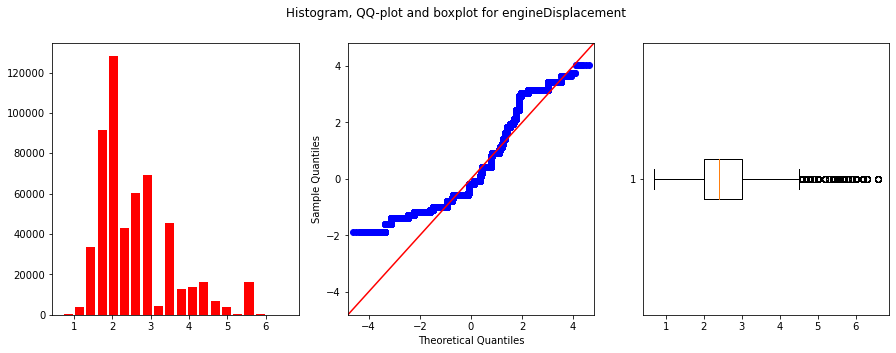

In [39]:
engineDisplacement = AnalyzNumCol(all_cars, 'engineDisplacement')
engineDisplacement.show_plots()

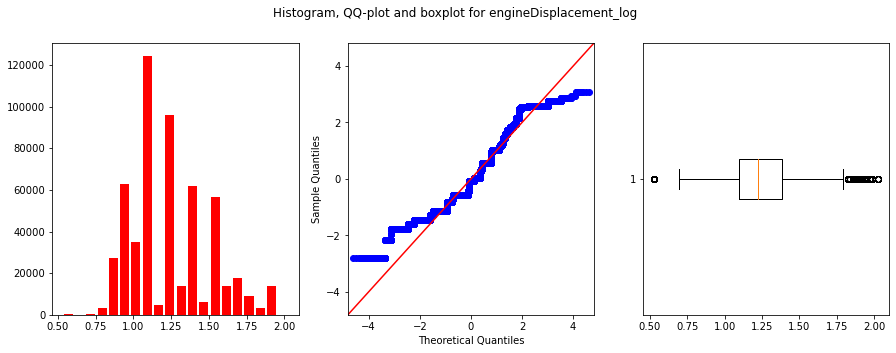

In [40]:
engineDisplacement.show_plots(log = True)

**Вывод**

Необходимо логорифмировать признак т.к. это улучшает нормальность распределения

In [41]:
all_cars['engineDisplacement'] = np.log(all_cars['engineDisplacement'] + 1)

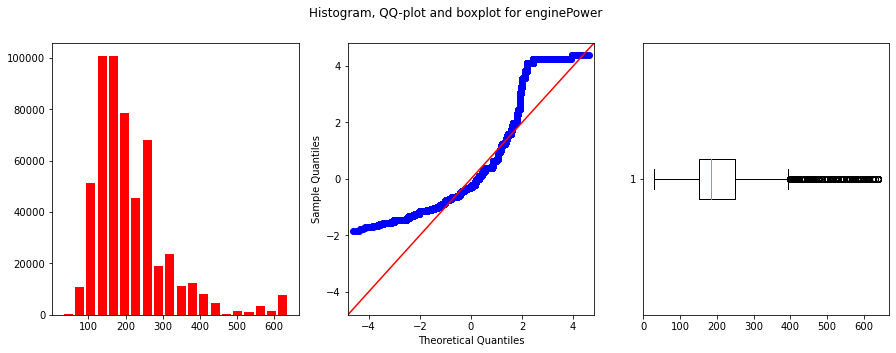

In [42]:
enginePower = AnalyzNumCol(all_cars, 'enginePower')
enginePower.show_plots()

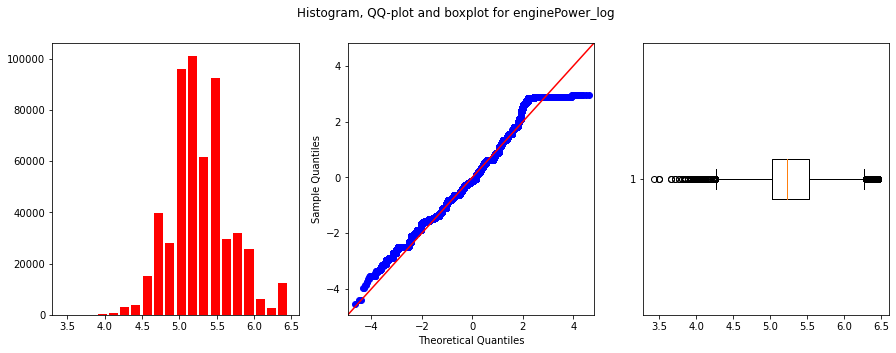

In [43]:
enginePower.show_plots(log = True)

**Вывод**

Необходимо логорифмировать признак т.к. это улучшает нормальность распределения

In [44]:
all_cars['enginePower'] = np.log(all_cars['enginePower'] + 1)#

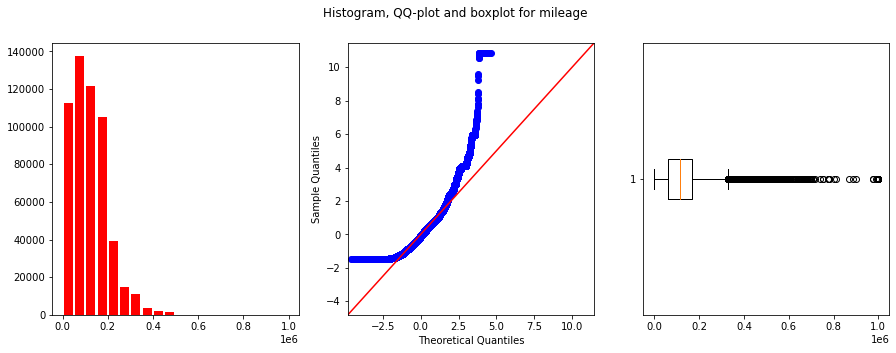

In [45]:
mileage = AnalyzNumCol(all_cars, 'mileage')
mileage.show_plots()

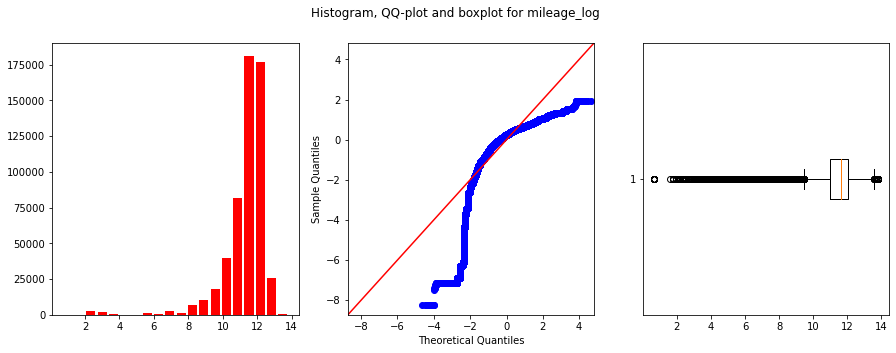

In [46]:
mileage.show_plots(log = True)

**Вывод**

Логорифмирование не дает ощутимого результата но применим ее.

In [47]:
#all_cars['mileage'] = np.log(all_cars['mileage'] + 1)

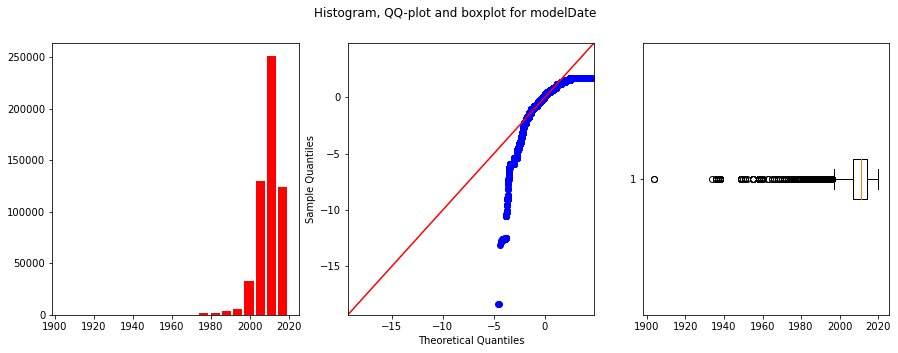

In [48]:
modelDate = AnalyzNumCol(all_cars, 'modelDate')
modelDate.show_plots()

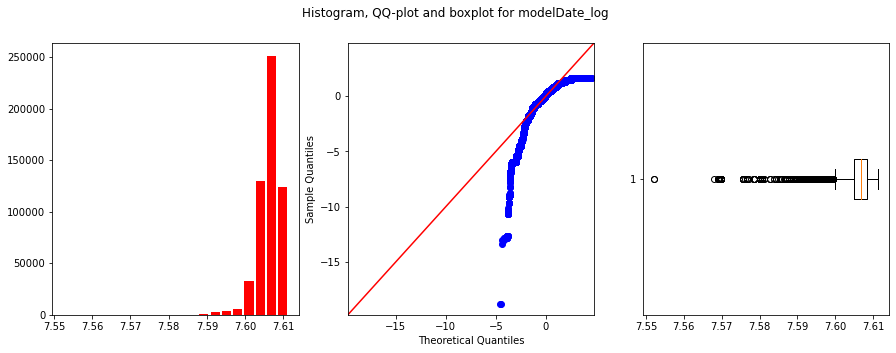

In [49]:
modelDate.show_plots(log = True)

**Вывод**

Распределение похоже на нормальное с длинным хвостом. Логорифмирование не улучшает ситуацию

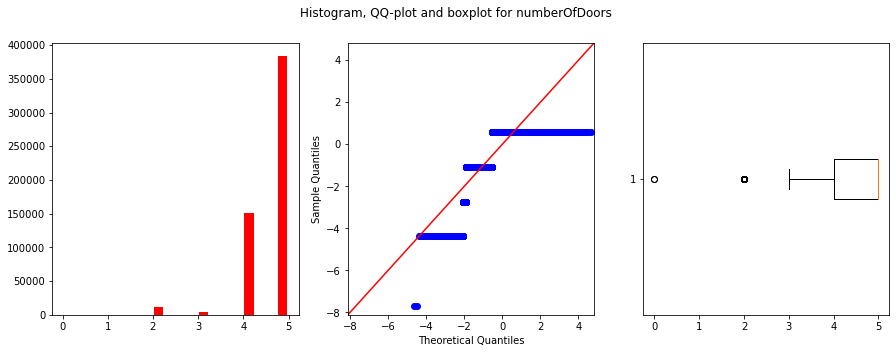

In [50]:
numberOfDoors = AnalyzNumCol(all_cars, 'numberOfDoors')
numberOfDoors.show_plots()

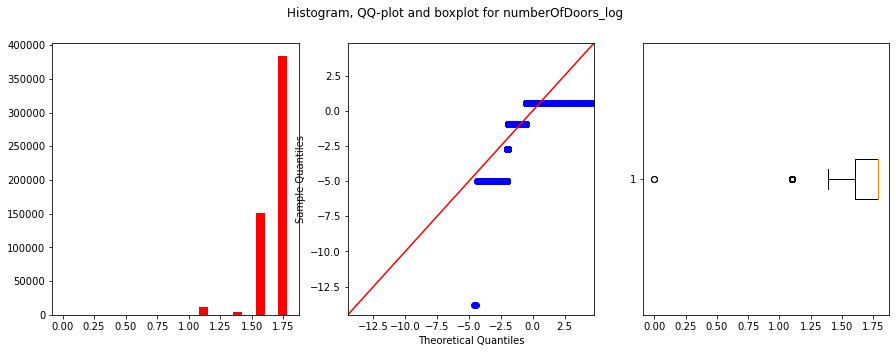

In [51]:
numberOfDoors.show_plots(log = True)

**Вывод**

Распределение похоже не нормальное. Логорифмирование не улучшает ситуацию. Признак можно отнести к категориальному

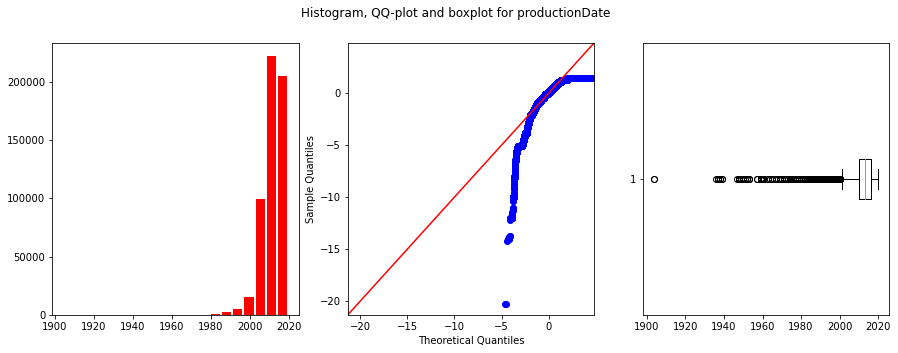

In [52]:
productionDate = AnalyzNumCol(all_cars, 'productionDate')
productionDate.show_plots()

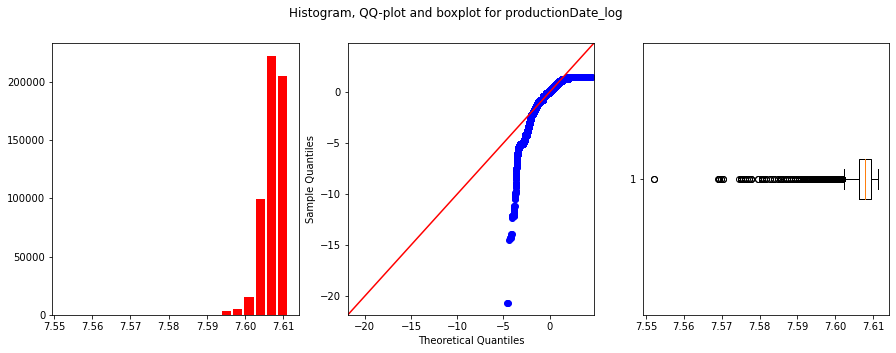

In [53]:
productionDate.show_plots(log = True)

**Вывод**

Распределение похоже на нормальное с длинным хвостом. Логорифмирование не улучшает ситуацию

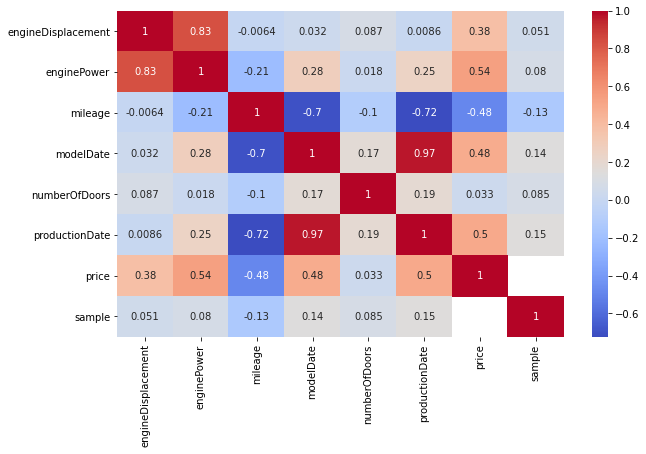

In [54]:
# Посмотрим корреляцию числовых признаков
correlation = all_cars.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

**Вывод**

1. Признаки enginePower и engineDisplacement имеют высокое зрначение корреляции, необходимо из них сделать новый (новые признаки).
2. Признаки productionDate и modelDate имеют высокое значение корреляции. на основе них создадь новый признак

In [55]:
all_cars.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'price', 'sample'], dtype='object')

In [56]:
columns = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleConfiguration', 'vehicleTransmission']

for column in columns:
    print(column, all_cars[column].nunique(), '\n', all_cars[column].value_counts()[:3], '\n')

bodyType 25 
 внедорожник 5 дв.    312619
седан                141441
лифтбек               29816
Name: bodyType, dtype: int64 

brand 12 
 BMW           48834
VOLKSWAGEN    48766
MERCEDES      48617
Name: brand, dtype: int64 

color 16 
 чёрный    179443
белый     101737
серый      64538
Name: color, dtype: int64 

fuelType 5 
 бензин    422680
дизель    119324
гибрид      6411
Name: fuelType, dtype: int64 

model_name 451 
 PAJERO    21624
RX        18992
CR        17487
Name: model_name, dtype: int64 

vehicleConfiguration 677 
 ALLROAD_5_DOORS AUTOMATIC 3.0    44869
ALLROAD_5_DOORS AUTOMATIC 2.0    44371
ALLROAD_5_DOORS AUTOMATIC 2.5    26167
Name: vehicleConfiguration, dtype: int64 

vehicleTransmission 4 
 автоматическая      357942
механическая         73942
роботизированная     66382
Name: vehicleTransmission, dtype: int64 



**Вывод**

1. model_name и vehicleConfiguration имеют большое количество вариантов.
2. Оставльные признаки можно предобрабатывать

# 4. Feature Engineering

In [57]:
# преобразуем признаки enginePower и engineDisplacement

pf = PolynomialFeatures(3)
#poly_features = pf.fit_transform(all_cars[[ 'engineDisplacement', 'enginePower']])
#poly = pd.DataFrame(poly_features).drop([0], axis = 1)
#poly.columns = ['displacement_power_1', 'displacement_power_2', 'displacement_power_3', 'displacement_power_4',
#               'displacement_power_5', 'displacement_power_6', 'displacement_power_7', 'displacement_power_8', 'displacement_power_9']

#poly.sample(5)


In [58]:
#for column in list(poly.columns):
#    max_column = poly[column].max()    
#    poly[column] = poly[column].apply(lambda x: round(x/max_column, 2))
    
#all_cars = pd.concat([all_cars, poly], axis=1)

In [59]:
num_f = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate']

In [60]:
#Аналогично проделаем со столбцами 

poly_features = pf.fit_transform(all_cars[['productionDate', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,4,5,7,8,9], axis = 1)
poly.columns = ['date_power_6']

for column in list(poly.columns):
    max_column = poly[column].max()     
    poly[column] = poly[column].apply(lambda x: round(x/max_column, 2))
    
all_cars = pd.concat([all_cars, poly], axis=1)
num_f = num_f + list(poly.columns)

In [61]:
all_cars['model_age'] = all_cars['productionDate'] - all_cars['modelDate']
all_cars['model_age'] = all_cars['model_age'].apply(lambda x: 0 if x < 0 else x)
all_cars['km_for_year'] = (all_cars['mileage']/(2021 - all_cars['productionDate'])).astype('int64')
num_f.append('model_age')
num_f.append('km_for_year')

In [62]:
all_cars['allroad'] = all_cars['vehicleConfiguration'].apply(lambda x: 1 if x.split('_')[0] == 'ALLROAD' else 0)
num_f.append('allroad')

In [63]:
#Закодируем данные кроме бренда

label_encoder = LabelEncoder()

for column in ['bodyType', 'color', 'fuelType', 'model_name', 'vehicleConfiguration', 'vehicleTransmission']:
    all_cars[column] = label_encoder.fit_transform(all_cars[column])

In [64]:
num_f = ['bodyType', 'color', 'enginePower', 'fuelType', 'mileage', 'model_name', 
         'numberOfDoors', 'vehicleTransmission', 'date_power_6', 'model_age', 
         'km_for_year']

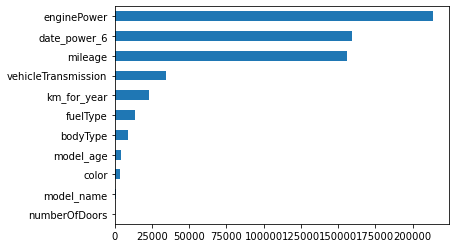

In [65]:
imp_num = Series(f_regression(all_cars[all_cars['sample'] == 1][num_f], all_cars[all_cars['sample'] == 1].price)[0], index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

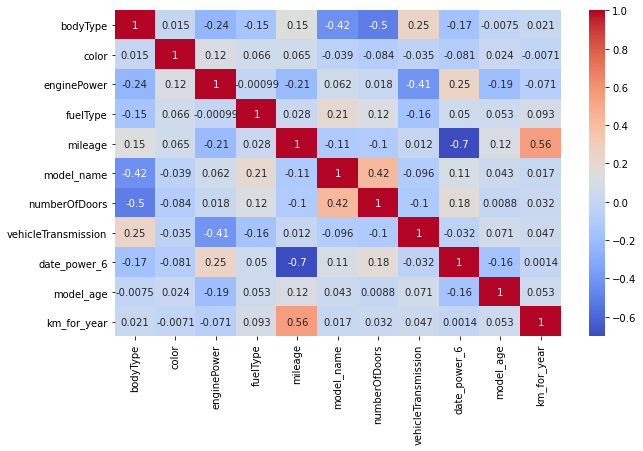

In [66]:
# Посмотрим корреляцию числовых признаков
correlation = all_cars[num_f].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [67]:
all_cars.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'price', 'sample', 'date_power_6', 'model_age', 'km_for_year', 'allroad'], dtype='object')

# 5. Построение модели.

Так как ранее было выявлено, что цена на автомобиль существенно влияет от торговой марки, то будем подбирать параметры под 12 моделей длч каждого бренда

In [68]:
all_cars.brand.value_counts().index

Index(['BMW', 'VOLKSWAGEN', 'MERCEDES', 'NISSAN', 'TOYOTA', 'AUDI', 'SKODA', 'MITSUBISHI', 'VOLVO', 'HONDA', 'LEXUS', 'INFINITI'], dtype='object')

In [69]:
data_for_model = all_cars[['brand', 'bodyType', 'color', 'enginePower', 'fuelType', 'mileage', 'model_name', 
                           'numberOfDoors', 'vehicleTransmission', 'date_power_6', 'model_age', 'km_for_year', 'price', 'sample']]

In [70]:
#stopper = 1/0

**5.1 Линейная Регрессия в разрезе моделей**

In [71]:
"""
train_BMW = data_for_model[(data_for_model['brand'] == 'BMW') & (data_for_model['sample'] == 1)].copy()
train_VOLKSWAGEN = data_for_model[(data_for_model['brand'] == 'VOLKSWAGEN') & (data_for_model['sample'] == 1)].copy()
train_NISSAN = data_for_model[(data_for_model['brand'] == 'NISSAN') & (data_for_model['sample'] == 1)].copy()
train_MERCEDES = data_for_model[(data_for_model['brand'] == 'MERCEDES') & (data_for_model['sample'] == 1)].copy()
train_AUDI = data_for_model[(data_for_model['brand'] == 'AUDI') & (data_for_model['sample'] == 1)].copy()
train_MITSUBISHI = data_for_model[(data_for_model['brand'] == 'MITSUBISHI') & (data_for_model['sample'] == 1)].copy()
train_SKODA = data_for_model[(data_for_model['brand'] == 'SKODA') & (data_for_model['sample'] == 1)].copy()
train_VOLVO = data_for_model[(data_for_model['brand'] == 'VOLVO') & (data_for_model['sample'] == 1)].copy()
train_HONDA = data_for_model[(data_for_model['brand'] == 'HONDA') & (data_for_model['sample'] == 1)].copy()
train_INFINITI = data_for_model[(data_for_model['brand'] == 'INFINITI') & (data_for_model['sample'] == 1)].copy()
train_LEXUS = data_for_model[(data_for_model['brand'] == 'LEXUS') & (data_for_model['sample'] == 1)].copy()
train_TOYOTA = data_for_model[(data_for_model['brand'] == 'TOYOTA') & (data_for_model['sample'] == 1)].copy()"""


"\ntrain_BMW = data_for_model[(data_for_model['brand'] == 'BMW') & (data_for_model['sample'] == 1)].copy()\ntrain_VOLKSWAGEN = data_for_model[(data_for_model['brand'] == 'VOLKSWAGEN') & (data_for_model['sample'] == 1)].copy()\ntrain_NISSAN = data_for_model[(data_for_model['brand'] == 'NISSAN') & (data_for_model['sample'] == 1)].copy()\ntrain_MERCEDES = data_for_model[(data_for_model['brand'] == 'MERCEDES') & (data_for_model['sample'] == 1)].copy()\ntrain_AUDI = data_for_model[(data_for_model['brand'] == 'AUDI') & (data_for_model['sample'] == 1)].copy()\ntrain_MITSUBISHI = data_for_model[(data_for_model['brand'] == 'MITSUBISHI') & (data_for_model['sample'] == 1)].copy()\ntrain_SKODA = data_for_model[(data_for_model['brand'] == 'SKODA') & (data_for_model['sample'] == 1)].copy()\ntrain_VOLVO = data_for_model[(data_for_model['brand'] == 'VOLVO') & (data_for_model['sample'] == 1)].copy()\ntrain_HONDA = data_for_model[(data_for_model['brand'] == 'HONDA') & (data_for_model['sample'] == 1)].co

**5.1.1 Регрессия** 

In [72]:
"""def model(data):
    X = data.drop(['brand', 'sample', 'price'], axis = 1)
    y = data['price']
    
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
    
    # Выделим из тренировочного датасета 20% на валидацию
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    #Обучим модель
    warnings.simplefilter('ignore')
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    resalt = mape(y_test, y_pred)
    
    return model, resalt

def pretreatment(data):
    X = data.drop(['brand', 'sample', 'price'], axis = 1)
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
    data = data.drop(['sample', 'price', 'brand'], axis = 1)
    X.index = data.index
    
    for column in data.columns:
        if column in X.columns:
            data[column] = X[column]
        else:
            data[column] = data[column]
            
    return data
    """

"def model(data):\n    X = data.drop(['brand', 'sample', 'price'], axis = 1)\n    y = data['price']\n    \n    X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)\n    \n    # Выделим из тренировочного датасета 20% на валидацию\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)\n    \n    #Обучим модель\n    warnings.simplefilter('ignore')\n    \n    model = LinearRegression()\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    resalt = mape(y_test, y_pred)\n    \n    return model, resalt\n\ndef pretreatment(data):\n    X = data.drop(['brand', 'sample', 'price'], axis = 1)\n    X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)\n    data = data.drop(['sample', 'price', 'brand'], axis = 1)\n    X.index = data.index\n    \n    for column in data.columns:\n        if column in X.columns:\n            data[column] = X[column]\n        else:\n            data[column] = data[

In [73]:
"""model_BNW,mape_BMW  = model(train_BMW)
model_VOLKSWAGEN,mape_VOLKSWAGEN  = model(train_VOLKSWAGEN)
model_NISSAN,mape_NISSAN  = model(train_NISSAN)
model_MERCEDES,mape_MERCEDES  = model(train_MERCEDES)
model_AUDI,mape_AUDI  = model(train_AUDI)
model_MITSUBISHI,mape_MITSUBISHI  = model(train_MITSUBISHI)
model_SKODA,mape_SKODA  = model(train_SKODA)
model_VOLVO,mape_VOLVO  = model(train_VOLVO)
model_HONDA,mape_HONDA  = model(train_HONDA)
model_INFINITI,mape_INFINITI  = model(train_INFINITI)
model_LEXUS,mape_LEXUS  = model(train_LEXUS)
model_TOYOTA,mape_TOYOTA  = model(train_TOYOTA)

dict_model = {'BMW': model_BNW, 'VOLKSWAGEN': model_VOLKSWAGEN, 'NISSAN': model_NISSAN,
             'MERCEDES': model_MERCEDES, 'AUDI': model_AUDI, 'MITSUBISHI': model_MITSUBISHI,
             'SKODA': model_SKODA, 'VOLVO': model_VOLVO, 'HONDA': model_HONDA,
             'INFINITI': model_INFINITI, 'LEXUS': model_LEXUS, 'TOYOTA': model_TOYOTA}


print(f'BMW: {mape_BMW}, VW: {mape_VOLKSWAGEN}, NISSAN {mape_NISSAN}, MERCEDES: {mape_MERCEDES}, AUDI:  {mape_AUDI}, MITSUBISHI {mape_MITSUBISHI}')
print(f'SKODA {mape_SKODA}, VOLVO {mape_VOLVO}, HONDA: {mape_HONDA}, INFINITI: {mape_INFINITI}, LEXUS: {mape_LEXUS}, TOYOTA: {mape_TOYOTA}')"""

"model_BNW,mape_BMW  = model(train_BMW)\nmodel_VOLKSWAGEN,mape_VOLKSWAGEN  = model(train_VOLKSWAGEN)\nmodel_NISSAN,mape_NISSAN  = model(train_NISSAN)\nmodel_MERCEDES,mape_MERCEDES  = model(train_MERCEDES)\nmodel_AUDI,mape_AUDI  = model(train_AUDI)\nmodel_MITSUBISHI,mape_MITSUBISHI  = model(train_MITSUBISHI)\nmodel_SKODA,mape_SKODA  = model(train_SKODA)\nmodel_VOLVO,mape_VOLVO  = model(train_VOLVO)\nmodel_HONDA,mape_HONDA  = model(train_HONDA)\nmodel_INFINITI,mape_INFINITI  = model(train_INFINITI)\nmodel_LEXUS,mape_LEXUS  = model(train_LEXUS)\nmodel_TOYOTA,mape_TOYOTA  = model(train_TOYOTA)\n\ndict_model = {'BMW': model_BNW, 'VOLKSWAGEN': model_VOLKSWAGEN, 'NISSAN': model_NISSAN,\n             'MERCEDES': model_MERCEDES, 'AUDI': model_AUDI, 'MITSUBISHI': model_MITSUBISHI,\n             'SKODA': model_SKODA, 'VOLVO': model_VOLVO, 'HONDA': model_HONDA,\n             'INFINITI': model_INFINITI, 'LEXUS': model_LEXUS, 'TOYOTA': model_TOYOTA}\n\n\nprint(f'BMW: {mape_BMW}, VW: {mape_VOLKSWAGEN

In [74]:
"""test_1 = data_for_model[data_for_model['sample'] == 0]
len(test_1)"""

"test_1 = data_for_model[data_for_model['sample'] == 0]\nlen(test_1)"

In [75]:
"""test_BMW = test_1[test_1['brand'] == 'BMW']
test_VOLKSWAGEN = test_1[test_1['brand'] == 'VOLKSWAGEN']
test_NISSAN = test_1[test_1['brand'] == 'NISSAN']
test_MERCEDES = test_1[test_1['brand'] == 'MERCEDES']
test_AUDI = test_1[test_1['brand'] == 'AUDI']
test_MITSUBISHI = test_1[test_1['brand'] == 'MITSUBISHI']
test_SKODA = test_1[test_1['brand'] == 'SKODA']
test_VOLVO = test_1[test_1['brand'] == 'VOLVO']
test_HONDA = test_1[test_1['brand'] == 'HONDA']
test_INFINITI = test_1[test_1['brand'] == 'INFINITI']
test_LEXUS = test_1[test_1['brand'] == 'LEXUS']
test_TOYOTA = test_1[test_1['brand'] == 'TOYOTA']"""

"test_BMW = test_1[test_1['brand'] == 'BMW']\ntest_VOLKSWAGEN = test_1[test_1['brand'] == 'VOLKSWAGEN']\ntest_NISSAN = test_1[test_1['brand'] == 'NISSAN']\ntest_MERCEDES = test_1[test_1['brand'] == 'MERCEDES']\ntest_AUDI = test_1[test_1['brand'] == 'AUDI']\ntest_MITSUBISHI = test_1[test_1['brand'] == 'MITSUBISHI']\ntest_SKODA = test_1[test_1['brand'] == 'SKODA']\ntest_VOLVO = test_1[test_1['brand'] == 'VOLVO']\ntest_HONDA = test_1[test_1['brand'] == 'HONDA']\ntest_INFINITI = test_1[test_1['brand'] == 'INFINITI']\ntest_LEXUS = test_1[test_1['brand'] == 'LEXUS']\ntest_TOYOTA = test_1[test_1['brand'] == 'TOYOTA']"

In [76]:
"""test_BMW = pretreatment(test_BMW)
test_VOLKSWAGEN = pretreatment(test_VOLKSWAGEN)
test_NISSAN = pretreatment(test_NISSAN)
test_MERCEDES = pretreatment(test_MERCEDES)
test_AUDI = pretreatment(test_AUDI)
test_MITSUBISHI = pretreatment(test_MITSUBISHI)
test_SKODA = pretreatment(test_SKODA)
test_VOLVO = pretreatment(test_VOLVO)
test_HONDA = pretreatment(test_HONDA)
test_INFINITI = pretreatment(test_INFINITI)
test_LEXUS = pretreatment(test_LEXUS)
test_TOYOTA = pretreatment(test_TOYOTA)"""


'test_BMW = pretreatment(test_BMW)\ntest_VOLKSWAGEN = pretreatment(test_VOLKSWAGEN)\ntest_NISSAN = pretreatment(test_NISSAN)\ntest_MERCEDES = pretreatment(test_MERCEDES)\ntest_AUDI = pretreatment(test_AUDI)\ntest_MITSUBISHI = pretreatment(test_MITSUBISHI)\ntest_SKODA = pretreatment(test_SKODA)\ntest_VOLVO = pretreatment(test_VOLVO)\ntest_HONDA = pretreatment(test_HONDA)\ntest_INFINITI = pretreatment(test_INFINITI)\ntest_LEXUS = pretreatment(test_LEXUS)\ntest_TOYOTA = pretreatment(test_TOYOTA)'

In [77]:
"""y_pred_BMW = model_BNW.predict(test_BMW)
test_BMW['y_pred'] = abs(y_pred_BMW)
test_VOLKSWAGEN['y_pred'] = abs(dict_model['VOLKSWAGEN'].predict(test_VOLKSWAGEN))
test_NISSAN['y_pred'] = abs(dict_model['NISSAN'].predict(test_NISSAN))
test_MERCEDES['y_pred'] = abs(dict_model['MERCEDES'].predict(test_MERCEDES))
test_AUDI['y_pred'] = abs(dict_model['AUDI'].predict(test_AUDI))
test_MITSUBISHI['y_pred'] = abs(dict_model['MITSUBISHI'].predict(test_MITSUBISHI))
test_SKODA['y_pred'] = abs(dict_model['SKODA'].predict(test_SKODA))
test_VOLVO['y_pred'] = abs(dict_model['VOLVO'].predict(test_VOLVO))
test_HONDA['y_pred'] = abs(dict_model['HONDA'].predict(test_HONDA))
test_INFINITI['y_pred'] = abs(dict_model['INFINITI'].predict(test_INFINITI))
test_LEXUS['y_pred'] = abs(dict_model['LEXUS'].predict(test_LEXUS))
test_TOYOTA['y_pred'] = abs(dict_model['TOYOTA'].predict(test_TOYOTA))"""

"y_pred_BMW = model_BNW.predict(test_BMW)\ntest_BMW['y_pred'] = abs(y_pred_BMW)\ntest_VOLKSWAGEN['y_pred'] = abs(dict_model['VOLKSWAGEN'].predict(test_VOLKSWAGEN))\ntest_NISSAN['y_pred'] = abs(dict_model['NISSAN'].predict(test_NISSAN))\ntest_MERCEDES['y_pred'] = abs(dict_model['MERCEDES'].predict(test_MERCEDES))\ntest_AUDI['y_pred'] = abs(dict_model['AUDI'].predict(test_AUDI))\ntest_MITSUBISHI['y_pred'] = abs(dict_model['MITSUBISHI'].predict(test_MITSUBISHI))\ntest_SKODA['y_pred'] = abs(dict_model['SKODA'].predict(test_SKODA))\ntest_VOLVO['y_pred'] = abs(dict_model['VOLVO'].predict(test_VOLVO))\ntest_HONDA['y_pred'] = abs(dict_model['HONDA'].predict(test_HONDA))\ntest_INFINITI['y_pred'] = abs(dict_model['INFINITI'].predict(test_INFINITI))\ntest_LEXUS['y_pred'] = abs(dict_model['LEXUS'].predict(test_LEXUS))\ntest_TOYOTA['y_pred'] = abs(dict_model['TOYOTA'].predict(test_TOYOTA))"

In [78]:
"""test_for_predict = pd.concat([test_BMW, test_VOLKSWAGEN, test_NISSAN, test_MERCEDES, test_AUDI, test_MITSUBISHI,
                             test_SKODA, test_VOLVO, test_HONDA, test_INFINITI, test_LEXUS, test_TOYOTA], axis = 0)"""

'test_for_predict = pd.concat([test_BMW, test_VOLKSWAGEN, test_NISSAN, test_MERCEDES, test_AUDI, test_MITSUBISHI,\n                             test_SKODA, test_VOLVO, test_HONDA, test_INFINITI, test_LEXUS, test_TOYOTA], axis = 0)'

In [79]:
"""test_for_predict = test_for_predict.sort_index()"""


'test_for_predict = test_for_predict.sort_index()'

In [80]:
"""test_for_predict['y_pred'] = round(test_for_predict['y_pred'], 0)"""

"test_for_predict['y_pred'] = round(test_for_predict['y_pred'], 0)"

In [81]:
#sample_submission = pd.DataFrame()
#sample_submission['sell_id'] = test['sell_id']
#test_for_predict.index = sample_submission.index
#sample_submission['price'] = test_for_predict['y_pred']
#sample_submission.to_csv('submission.csv', index=False)
#sample_submission.head()

**Вывод**

В результате публикации результатов данной моделей оценка получилась 146.67

5.2 Случайный лес 

In [82]:
all_cars['brand'] = label_encoder.fit_transform(all_cars['brand'])

data_for_model = all_cars.copy()

y = data_for_model[data_for_model['sample'] == 1]['price']
X = data_for_model[data_for_model['sample'] == 1].drop(['price', 'sample'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [83]:
test_for_pred = data_for_model[data_for_model['sample'] == 0]

test_for_pred = test_for_pred.drop(['price', 'sample'], axis = 1)

In [84]:
"""model = RandomForestRegressor(random_state=RANDOM_SEED)

model.fit(X_train, y_train)
test_predict = model.predict(X_test)

mape(y_test, test_predict)"""

'model = RandomForestRegressor(random_state=RANDOM_SEED)\n\nmodel.fit(X_train, y_train)\ntest_predict = model.predict(X_test)\n\nmape(y_test, test_predict)'

In [85]:
"""y_pred = model.predict(test_for_pred)"""

'y_pred = model.predict(test_for_pred)'

In [86]:
"""sample_submission = pd.DataFrame()
sample_submission['sell_id'] = test['sell_id']
#test_for_predict.index = sample_submission.index
sample_submission['price'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()"""

"sample_submission = pd.DataFrame()\nsample_submission['sell_id'] = test['sell_id']\n#test_for_predict.index = sample_submission.index\nsample_submission['price'] = y_pred\nsample_submission.to_csv('submission.csv', index=False)\nsample_submission.head()"

**Вывод**

Оценка на kaggle 19.06908



**Вывод**

Подберем гиперпараметры для модели

In [87]:
"""n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]"""

"n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]\nmax_features = ['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 110, 11)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 4]\nbootstrap = [True, False]"

In [88]:
"""random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}"""

"random_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}"

In [89]:
"""model = RandomForestRegressor(random_state=RANDOM_SEED, 
                              n_estimators=300, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_features='sqrt', 
                              max_depth=None, 
                              bootstrap=False)

model.fit(X_train, y_train)
test_predict = model.predict(X_test)

mape(y_test, test_predict)"""

"model = RandomForestRegressor(random_state=RANDOM_SEED, \n                              n_estimators=300, \n                              min_samples_split=2, \n                              min_samples_leaf=1, \n                              max_features='sqrt', \n                              max_depth=None, \n                              bootstrap=False)\n\nmodel.fit(X_train, y_train)\ntest_predict = model.predict(X_test)\n\nmape(y_test, test_predict)"

In [90]:
"""y_pred = model.predict(test_for_pred)"""

'y_pred = model.predict(test_for_pred)'

In [91]:
"""sample_submission = pd.DataFrame()
sample_submission['sell_id'] = test['sell_id']
#test_for_predict.index = sample_submission.index
sample_submission['price'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()"""

"sample_submission = pd.DataFrame()\nsample_submission['sell_id'] = test['sell_id']\n#test_for_predict.index = sample_submission.index\nsample_submission['price'] = y_pred\nsample_submission.to_csv('submission.csv', index=False)\nsample_submission.head()"

In [92]:
"""model_forest = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                               n_iter = 3, cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)
model_forest.fit(X_train, y_train)


model_forest.best_params_"""

'model_forest = RandomizedSearchCV(estimator = model, param_distributions = random_grid, \n                               n_iter = 3, cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)\nmodel_forest.fit(X_train, y_train)\n\n\nmodel_forest.best_params_'

**5.3 CatBoost**

In [93]:
data_for_model = all_cars.copy()

y = data_for_model[data_for_model['sample'] == 1]['price']
X = data_for_model[data_for_model['sample'] == 1].drop(['price', 'sample'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

**Вывод**

1. Оптимальное количество итерации - 15500
2. Шаг - 0.027
3. Оценка на сабмишионе - 14.74931

In [94]:
# !Логарифмироварие целевой переменной улучшает результат на 20%!
y_train = y_train.apply(lambda x: math.log(x))
y_test = y_test.apply(lambda x: math.log(x))
X = train.values
y = y.apply(lambda x: math.log(x)).values


In [95]:

ITERATIONS = 15500
model = CatBoostRegressor(loss_function = 'RMSE',
                          iterations = ITERATIONS,
                          depth = 8,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE'
                         )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026073
0:	learn: 0.0443824	test: 0.0444478	best: 0.0444478 (0)	total: 166ms	remaining: 42m 47s
500:	learn: 0.0028645	test: 0.0029194	best: 0.0029194 (500)	total: 47.8s	remaining: 23m 49s
1000:	learn: 0.0016973	test: 0.0017739	best: 0.0017739 (1000)	total: 1m 35s	remaining: 22m 57s
1500:	learn: 0.0012689	test: 0.0013648	best: 0.0013648 (1500)	total: 2m 22s	remaining: 22m 12s
2000:	learn: 0.0010483	test: 0.0011598	best: 0.0011598 (2000)	total: 3m 13s	remaining: 21m 45s
2500:	learn: 0.0009050	test: 0.0010306	best: 0.0010306 (2500)	total: 4m 4s	remaining: 21m 11s
3000:	learn: 0.0008058	test: 0.0009443	best: 0.0009443 (2999)	total: 4m 56s	remaining: 20m 36s
3500:	learn: 0.0007338	test: 0.0008840	best: 0.0008840 (3500)	total: 5m 49s	remaining: 19m 58s
4000:	learn: 0.0006738	test: 0.0008340	best: 0.0008340 (4000)	total: 6m 45s	remaining: 19m 24s
4500:	learn: 0.0006267	test: 0.0007968	best: 0.0007968 (4500)	total: 7m 41s	remaining: 18m 46s
5000:	learn: 0.0005865	test: 0.

In [96]:
y_pred = model.predict(X_test)
mape(y_test, y_pred)

0.0005931268651587883

Применим кросс-валидацию с 5 фолдами

In [97]:
data_for_model = all_cars.copy()

y = data_for_model[data_for_model['sample'] == 1]['price']
X = data_for_model[data_for_model['sample'] == 1].drop(['price', 'sample'], axis = 1)

y = y.apply(lambda x: math.log(x))

In [98]:
def CV_cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(loss_function = 'RMSE',
                              iterations = 5000,
                              depth = 8,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE'
                             )
    model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose_eval=500,
              use_best_model=True,
              plot=False)
    
    return(model)

In [101]:
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [ ]:
N_FOLDS = 5
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X,y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    Xf_train, yf_train, Xf_test, yf_test = X.loc[train_idx], y.loc[train_idx], X.loc[test_idx], y.loc[test_idx]
    
    model = CV_cat_model(yf_train, Xf_train, Xf_test, yf_test)
    
    # score model on test
    test_predict = model.predict(Xf_test)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.4f}%")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test_for_pred)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls)*100:0.4f}%')
print(f'Std Score: {np.std(score_ls)*100:0.4f}%')
print(f'Max Score: {np.max(score_ls)*100:0.4f}%')
print(f'Min Score: {np.min(score_ls)*100:0.4f}%')



  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.052761
0:	learn: 0.0432963	test: 0.0433611	best: 0.0433611 (0)	total: 111ms	remaining: 9m 16s
500:	learn: 0.0016520	test: 0.0017245	best: 0.0017245 (500)	total: 44s	remaining: 6m 35s


In [ ]:
submissions['mix'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = np.round(submissions['mix'].apply(lambda x: math.exp(x)).values, 0)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

Лучший результат который на оценке дал 14.74931

**5.4. Bagging.¶**

In [ ]:
"""# Посмотрим сначала на точность одного дерева
tree = DecisionTreeRegressor(max_features=int(X_train.shape[1]/3), max_depth=77)
tree.fit(X_train, y_train)
test_predict = tree.predict(X_test)
mape(y_test, test_predict)"""

In [ ]:
"""bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, y_train)
test_predict = bagging_trees.predict(X_test)
mape(y_test, test_predict)"""

**Вывод**

Бэгинг улучшил точность одного дерева

**5. GradientBoosting**

In [ ]:
"""gb = GradientBoostingRegressor(max_depth=7,n_estimators=1500,learning_rate=0.1,random_state=42)#
gb.fit(X_train, y_train)
test_predict = gb.predict(X_test)
mape(y_test, test_predict)"""

In [ ]:
"""y_pred = gb.predict(test_for_pred)"""

In [ ]:
"""sample_submission = pd.DataFrame()
sample_submission['sell_id'] = test['sell_id']
#test_for_predict.index = sample_submission.index
sample_submission['price'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()"""

**Вывод**

Оценка в соревновании 18.06552

**6. Stacking**

In [ ]:
"""data_for_model = all_cars.copy()

y = data_for_model[data_for_model['sample'] == 1]['price']
X = data_for_model[data_for_model['sample'] == 1].drop(['price', 'sample'], axis = 1)

X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

y = y.apply(lambda x: math.log(x))

X = X.values
y = y.values
"""


In [ ]:
"""X_pred = test_for_pred

X_pred.index = test.index

X_pred = pd.DataFrame(StandardScaler().fit_transform(X_pred), columns = X_pred.columns)

X_pred = X_pred.values"""

In [ ]:
"""cv = KFold(n_splits=5, shuffle=True)"""

In [ ]:
"""def compute_meta_feature(clf, X_train, X_test, y_train, cv):
   
    Computes meta-features using the regression.
    
   
   
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    return X_meta_train, X_meta_test"""

In [ ]:
"""def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):
    
    Generates metafeatures using a list of regression.
    
   
    
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test"""

In [ ]:
"""stacked_features_train, stacked_features_test = generate_metafeatures([
    RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                          max_features=7,max_depth=77, bootstrap=True, random_state=42),
    AdaBoostRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    RandomForestRegressor(random_state=42)], X, X_pred, y, cv)"""

In [ ]:
"""total_features_train = np.hstack([X, stacked_features_train])
total_features_test = np.hstack([X_pred, stacked_features_test])"""

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(total_features_train, y, test_size=0.2, random_state=RANDOM_SEED)"""

In [ ]:
"""ITERATIONS = 15500
model = CatBoostRegressor(loss_function = 'RMSE',
                          iterations = ITERATIONS,
                          depth = 8,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE'
                         )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True,
          plot=True)"""

In [ ]:
"""y_pred_test = model.predict(y_test)"""

In [ ]:
"""mape(y_pred_test, y_test)"""

In [ ]:
"""y_pred = model.predict(total_features_test)"""

In [ ]:
"""sample_submission = pd.DataFrame()
sample_submission['sell_id'] = test['sell_id']
#test_for_predict.index = sample_submission.index
sample_submission['price'] = y_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: math.exp(x))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()"""

# Вывод

1. С авто.ру получено 515446 объявлений
2. Признаки унифицированы с признаками из теста
3. Проведены анализ признаков, оценка их важности и скоррелированности
4. Созданы новые признаки и отобран набор для работы с алгоритмами
5. Протестировано 6 типов алгоритмов с регрессорами

# Лучшую оценку на submission выдал CatBoost с кросс-валидацией

